# U.S. States

This notebook contains scripts that generate a dataset of U.S. states, based on the data from the U.S. Census Bureau. The generated dataset has the following structure:

* `fips_code` - FIPS code of the U.S. state.
* `usps_abbr` - two-symbol USPS state abbreviation.
* `name` - a name of the U.S. state.
* `geometry` - a geographical shape of the U.S. state (not included in CSV).

The script generates the dataset in CSV and Shape formats. Result files are stored in the output directory, specified by the `OUTBOUND_PATH` constant.

In [1]:
'''
Notebook parameters.
'''

DOWNLOAD = False
GEODATA_YEAR = "2021"
GEODATA_BASE_URI = "https://www2.census.gov/geo/tiger"

INBOUND_PATH = "../data/inbound/geo"
OUTBOUND_PATH = "../data/outbound/geo"

In [2]:
'''
Define U.S. regions.
'''

NEW_ENGLAND         = ["CT", "ME", "MA", "NH", "RI", "VT"]
MIDDLE_ATLANTIC     = ["NJ", "NY", "PA"]
EAST_NORTH_CENTRAL  = ["IN", "IL", "MI", "OH", "WI"]
WEST_NORTH_CENTRAL  = ["IA", "KS", "MN", "MO", "NE", "ND", "SD"]
SOUTH_ATLANTIC      = ["DE", "DC", "FL", "GA", "MD", "NC", "SC", "VA", "WV"]
EAST_SOUTH_CENTRAL  = ["AL", "KY", "MS", "TN"]
WEST_SOUTH_CENTRAL  = ["AR", "LA", "OK", "TX"]
MOUNTAIN            = ["AZ", "CO", "ID", "NM", "MT", "UT", "NV", "WY"]
PACIFIC             = ["CA", "OR", "WA"]
OCEAN               = ["AK", "HI"]

NORTHEAST           = NEW_ENGLAND + MIDDLE_ATLANTIC
MIDWEST             = EAST_NORTH_CENTRAL + WEST_NORTH_CENTRAL
SOUTH               = SOUTH_ATLANTIC + EAST_SOUTH_CENTRAL + WEST_SOUTH_CENTRAL
WEST                = MOUNTAIN + PACIFIC
CONTINENTAL         = NORTHEAST + MIDWEST + SOUTH + WEST

In [3]:
'''
Import dependencies.
'''

import os
import wget

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [4]:
'''
Download and initialize states dataframe.
'''

filename = "tl_" + GEODATA_YEAR + "_us_state.zip"

if DOWNLOAD:
    # download dataset
    source = GEODATA_BASE_URI + "/TIGER" + GEODATA_YEAR + "/STATE/" + filename
    dest = INBOUND_PATH + "/" + filename
    if os.path.exists(dest):
        os.remove(dest)
    wget.download(source, dest)

# create dataframe
states = gpd.read_file(INBOUND_PATH + "/" + filename, compression="zip")

# drop unnecessary columns
states.drop(
    [
        "REGION", "DIVISION", "GEOID", 
        "STATENS", "LSAD", "MTFCC", "FUNCSTAT", 
        "ALAND", "AWATER", "INTPTLAT", "INTPTLON"
    ],
    axis=1,
    inplace=True,
)

# rename columns
states.rename(
    columns={
        "STATEFP": "fips_code",
        "STUSPS": "usps_abbr",
        "NAME": "name",
    },
    inplace=True
)

# normalize column types
states.fips_code = states.fips_code.astype("string")
states.usps_abbr = states.usps_abbr.astype("string")
states.name = states.name.astype("string")

states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   fips_code  56 non-null     string  
 1   usps_abbr  56 non-null     string  
 2   name       56 non-null     string  
 3   geometry   56 non-null     geometry
dtypes: geometry(1), string(3)
memory usage: 1.9 KB


In [5]:
states.sort_values("usps_abbr")

,fips_code,usps_abbr,name,geometry
40,02,AK,Alaska,"MULTIPOLYGON (((-179.23023 51.28393, -179.2256..."
22,01,AL,Alabama,"POLYGON ((-85.48830 30.99706, -85.48917 30.997..."
43,05,AR,Arkansas,"POLYGON ((-90.95577 34.11871, -90.95451 34.117..."
41,60,AS,American Samoa,"MULTIPOLYGON (((-170.66633 -14.37578, -170.667..."
55,04,AZ,Arizona,"POLYGON ((-110.75069 37.00301, -110.74193 37.0..."
13,06,CA,California,"MULTIPOLYGON (((-116.10617 32.61848, -116.1085..."
26,08,CO,Colorado,"POLYGON ((-105.15504 36.99526, -105.15543 36.9..."
10,09,CT,Connecticut,"POLYGON ((-72.52790 41.17777, -72.55156 41.173..."
53,11,DC,District of Columbia,"POLYGON ((-77.11975 38.93435, -77.11886 38.935..."
11,10,DE,Delaware,"POLYGON ((-75.13846 39.00270, -75.13465 38.997..."


In [6]:
'''
Store in CSV and Shape formats.
'''

states.to_file(OUTBOUND_PATH + "/us_states.shp.zip")
states.drop(["geometry"], axis=1).to_csv(OUTBOUND_PATH + "/us_states.csv", index=False)

<AxesSubplot: >

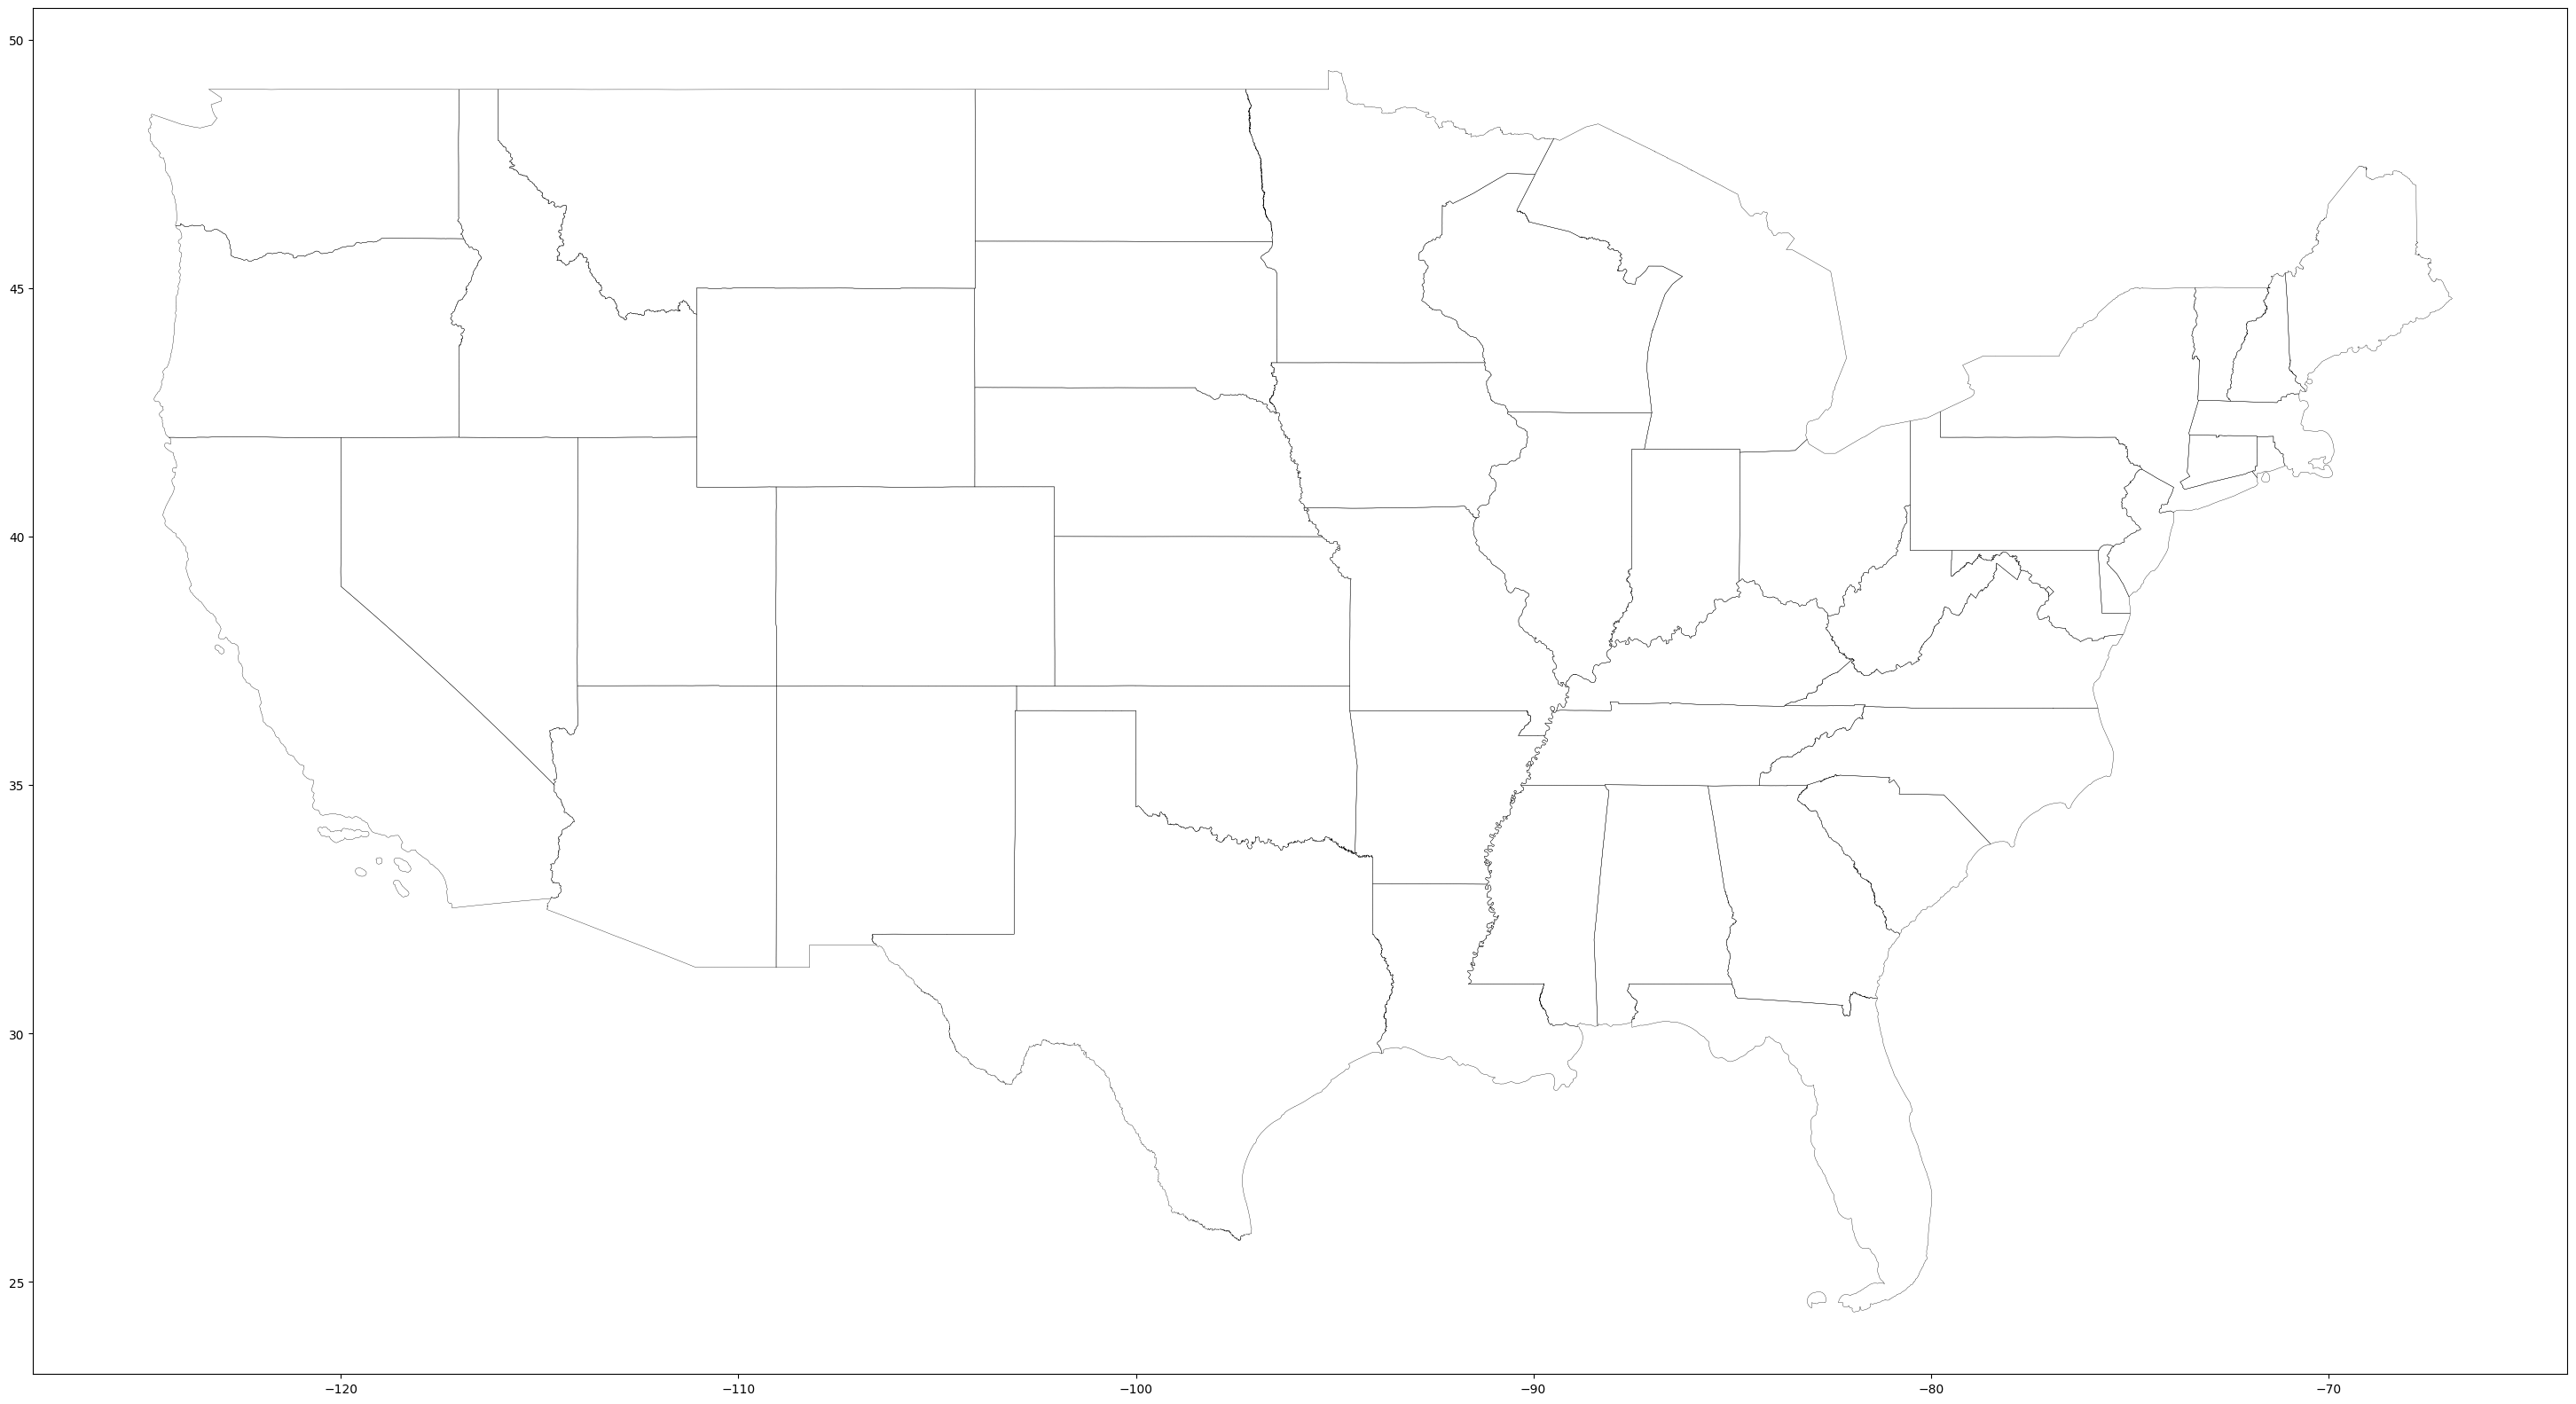

In [7]:
'''
Plot U.S. states on map.
'''
%matplotlib inline

# take only continental part of the U.S.
states_map = states[states.usps_abbr.isin(CONTINENTAL)]

fig = plt.figure(0, figsize=(80,20)) 
plot = fig.add_subplot()

states_map.boundary.plot(
    ax=plot, zorder=1,
    linewidth=0.25, color="black",
)